In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import seaborn as sns

import lrp
import utility

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# Load the dataset and classifier

In [5]:
# Valid datasets are "MNIST" and "CIFAR10"
data = "MNIST" 

In order to recieve the best results with this LRP implementation, the input data is scaled to the values [-1,...,1]

In [4]:
(x_train, y_train, x_test, y_test) = utiliy.load_dataset(data)

NameError: name 'utiliy' is not defined

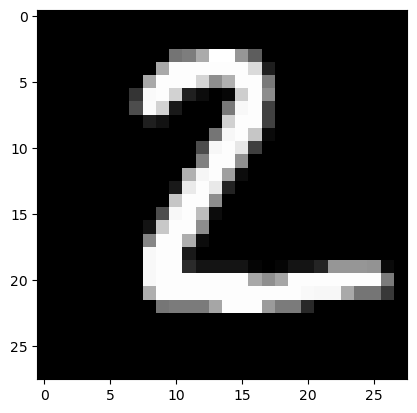

In [7]:
plt.imshow(x_test[1,:,:,0], cmap="gray")

# Train a model or load a model

In [24]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.models import Model

In [25]:
if True:
    inputs =  Input(shape=(28,28,1))
    conv1 = Conv2D(32,(3,3),activation="relu", padding="same")(inputs)
    conv2 = Conv2D(32,(3,3),activation="relu", padding="same")(conv1)
#     bn1 = BatchNormalization()(conv2) # remove
    pool1 = MaxPooling2D(pool_size=(2,2))(conv2)
    
    conv3 = Conv2D(64,(3,3),activation="relu", padding="same")(pool1)
    conv4 = Conv2D(64,(3,3),activation="relu", padding="same")(conv3)
#     bn2 = BatchNormalization()(conv4) # remove
    pool2 = MaxPooling2D(pool_size=(2,2))(conv4)    

    flat = Flatten()(pool2)
    dense1 = Dense(units=128, activation ="sigmoid")(flat)
    output = Dense(units=10, activation ="softmax")(dense1)
    classifier = Model(inputs = inputs, outputs = output)
# keras.utils.plot_model(classifier)


In [26]:
if True :classifier.compile(optimizer=keras.optimizers.Adam(1e-03), loss = ["categorical_crossentropy"],metrics=["accuracy",
                                                                                                            tf.keras.metrics.Recall(),
                                                                                                           tf.keras.metrics.Precision()])

In [27]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=0)
(train, val) = list(sss.split(x_train,y_train))[0]

In [28]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0, # Randomly zoom image 
        width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [29]:
model_path = os.path.join("models", "cnn_mnist", "model1.ckpt")
model_dir = os.path.dirname(model_path)

Epoch 1/10
26/26 [==============================] - 21s 777ms/step - loss: 1.4867 - accuracy: 0.5629 - recall_1: 0.2670 - precision_1: 0.9315 - val_loss: 0.5386 - val_accuracy: 0.8621 - val_recall_1: 0.7611 - val_precision_1: 0.9357
Epoch 2/10
26/26 [==============================] - 23s 886ms/step - loss: 0.3815 - accuracy: 0.9021 - recall_1: 0.8504 - precision_1: 0.9471 - val_loss: 0.2605 - val_accuracy: 0.9368 - val_recall_1: 0.9080 - val_precision_1: 0.9624
Epoch 3/10
26/26 [==============================] - 25s 981ms/step - loss: 0.2062 - accuracy: 0.9499 - recall_1: 0.9298 - precision_1: 0.9683 - val_loss: 0.1593 - val_accuracy: 0.9619 - val_recall_1: 0.9469 - val_precision_1: 0.9760
Epoch 4/10
26/26 [==============================] - 25s 979ms/step - loss: 0.1329 - accuracy: 0.9678 - recall_1: 0.9570 - precision_1: 0.9792 - val_loss: 0.1126 - val_accuracy: 0.9736 - val_recall_1: 0.9650 - val_precision_1: 0.9830
Epoch 5/10
26/26 [==============================] - 25s 966ms/step -

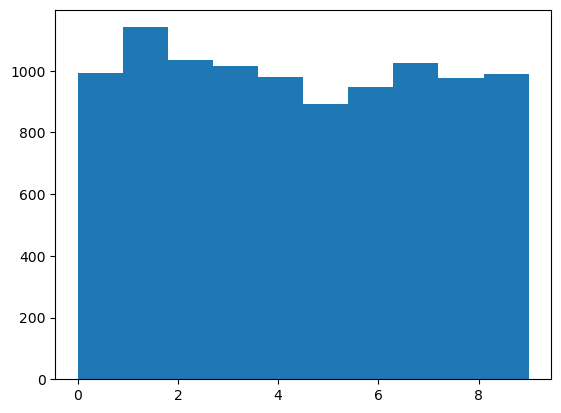

In [30]:
tmp_hist = []
tmp =  classifier.fit(datagen.flow(x_train[train], y_train[train], batch_size=2000), epochs = 10,
                                   validation_data = (x_train[val,:], y_train[val,:]))
y_pred = classifier.predict(x_test)
plt.hist(list(map(np.argmax, y_pred)))
plt.show()
tmp_hist.append(tmp)

In [32]:
# classifier = tf.keras.models.load_model(os.path.join("mnist5.hdf5"))
tf.keras.models.save_model(classifier, "mnist5_2.hdf5")

In [34]:
classifier.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 64)        36928     
                                                          

### Create an explainer object

In [43]:
explainer = lrp.LrpExplainer(classifier, 
                             ["final", "ab", "avg", "ab", "ab", "avg", "flatten", "eps", "0"], #this LRP process must define a rule for each layer. for reference what rule to choose, see here: https://iphome.hhi.de/samek/pdf/MonXAI19.pdf
                             a = 2, b = -1,  #These are hyper parameters a & b, according to LRP specificationsw
                             verbose = True) #Enables additional printouts and returns of the relprop function

### As verbose is True, additional logs are printed and returned

In [36]:
img = x_test[1,...]
label = y_test[1,...]

In [37]:
R, inputs, outputs, weights, biases, rs = explainer.relprop(img, label)

calculating LRP of  <keras.engine.functional.Functional object at 0x00000212B89A4A00>
['final', 'ab', 'avg', 'ab', 'ab', 'avg', 'flatten', 'eps', '0']
###################
getting values
propagating relevance regarding classification:  2
In layer  -1  :  <keras.layers.core.dense.Dense object at 0x00000212B89A4C70>  check-value:  0.997840397161651
In layer  -2  :  <keras.layers.core.dense.Dense object at 0x00000212B8C65F60>  check-value:  0.9986942752137885
In layer  -3  :  <keras.layers.reshaping.flatten.Flatten object at 0x00000212B8D059F0>  check-value:  0.9986942752137885
In layer  -4  :  <keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000212BACE35B0>  check-value:  0.9986942752137884
In layer  -5  :  <keras.layers.convolutional.conv2d.Conv2D object at 0x00000212B8D07940>  check-value:  0.99869406
In layer  -6  :  <keras.layers.convolutional.conv2d.Conv2D object at 0x00000212B9162650>  check-value:  0.9986942
In layer  -7  :  <keras.layers.pooling.max_pooling2d.MaxPool

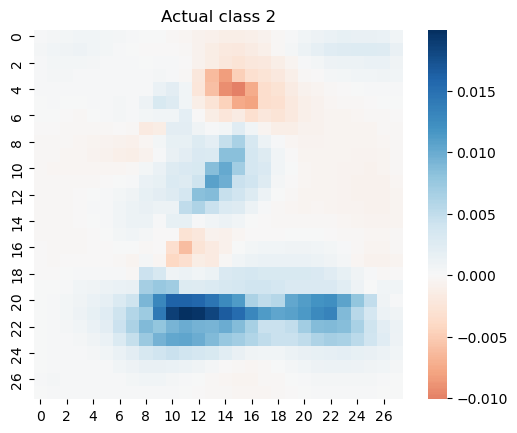

In [38]:
sns.heatmap(((R.sum(axis=3)[0,:,:])),center=0, vmax=np.max(R.sum(axis=3)[0,:,:]), vmin=np.min(R.sum(axis=3)[0,:,:]),cmap="RdBu", square=True)
_=plt.title("Actual class "+str(np.argmax(label)))

## Creating an adversarial attack and checking out the result

For the sake of this demonstration, we set verbose to False as to not get too many relprop log printouts

In [44]:
explainer = lrp.LrpExplainer(classifier, 
                             ["final", "ab", "avg", "ab", "ab", "avg", "flatten", "eps", "0"], #this LRP process must define a rule for each layer. for reference what rule to choose, see here: https://iphome.hhi.de/samek/pdf/MonXAI19.pdf
                             a = 2, b = -1,  #These are hyper parameters a & b, according to LRP specificationsw
                             verbose = False) #Enables additional printouts and returns of the relprop function

In [45]:
adv_img_flip = explainer.flip_attack(img, label, flips = 100)
adv_img_ifgsm = explainer.ifgsm_attack(img, label, flips = 100, eps = 2/256)
adv_img_lrp = explainer.lrp_attack_batch_grad(img, label, flips = 100, batch = 20, eps = 2/256)
adv_imgs = dict({"flip": adv_img_flip, "ifgsm": adv_img_ifgsm, "lrp": adv_img_lrp})

1/1 [==============================] - 0s 23ms/step


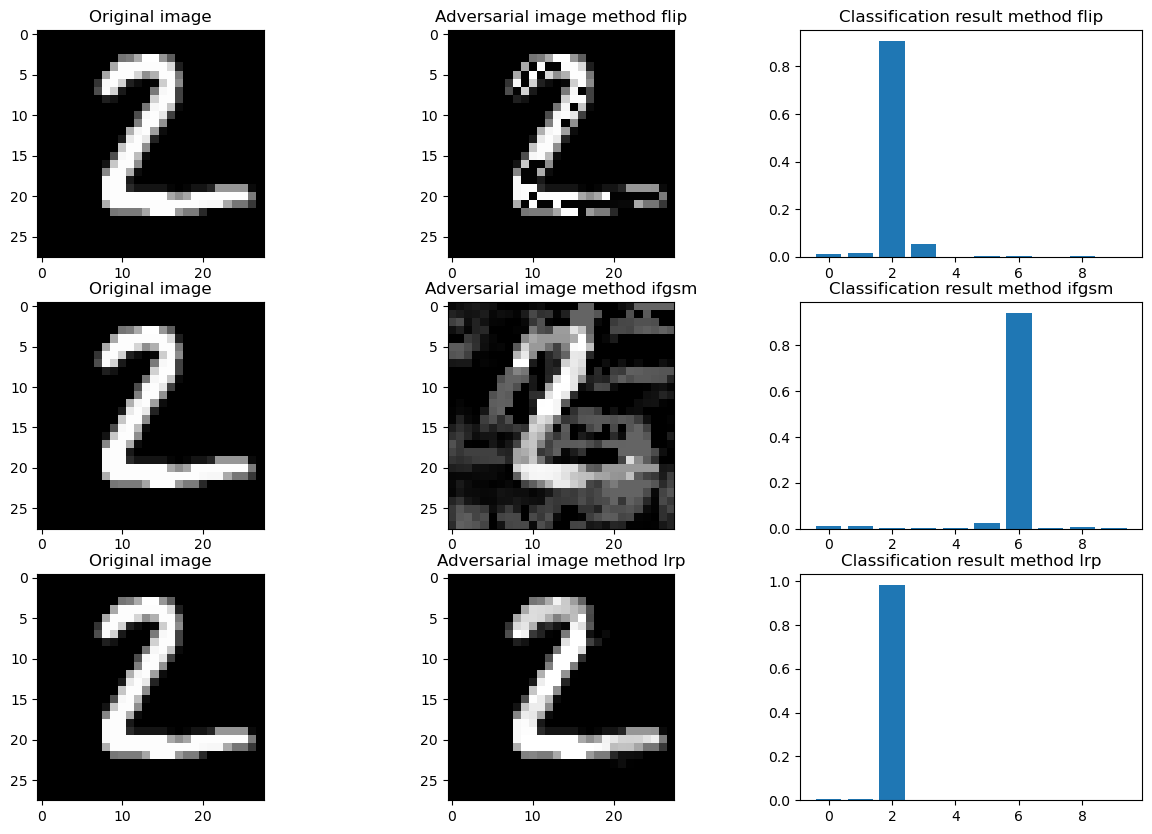

In [47]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (15,10))

for i, method in enumerate(adv_imgs.keys()):
    axs[i,0].imshow(img, cmap = "gray")
    axs[i,0].set_title("Original image")
    axs[i,1].imshow(adv_imgs[method], cmap = "gray")
    axs[i,1].set_title(f"Adversarial image method {method}")
    axs[i,2].bar(range(0,10), classifier.predict(adv_imgs[method].reshape([1]+ list(adv_imgs[method].shape)))[0])
    axs[i,2].set_title(f"Classification result method {method}")